# pycen
Lightweight Python package for exploring and acquiring U.S. Census data with intuitive spatial integration.

In [1]:
import pycen
from pycen import explore, acquire

## 4. Acquire (boundaries, tables; then manipulate + join)
- `acquire.get_census()` -- census data only (tabular)
    - see `3_acquire_tabular.ipynb` for details
- `acquire.get_boundaries()` -- boundary files (spatial)
    - <mark>this notebook</mark>
- `acquire.get_censhp()` -- **both at once** (GeoDataframe) 
    - see `2_acquire_spatial.ipynb` for details
---
- `acquire.quick_check()` - fast data quality checks
- `acquire.quick_viz()` - rapid visualizations
- use other packages as needed for data manipulation and analysis
---
`acquire.get_censhp()` would be handy for most times, but manual join allow customized processing such as loops, multi-patch download, append other non-census variables

### 4.1 `acquire.get_boundaries()` - get boundaries only

In [2]:
# tract-level geometry-only file for Alameda County
bnd = acquire.get_boundaries(
      geography='tract',
      state='CA',
      county='Alameda',
      year=2021
  )
bnd.head()

  State: California (CA, FIPS: 06)
  County: Alameda County (FIPS: 001)
Fetching boundaries...


,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,geometry
9,06,001,451704,1400000US06001451704,06001451704,4517.04,Census Tract 4517.04,CA,Alameda County,California,CT,2005363,0,"POLYGON ((-121.79849 37.66071, -121.79821 37.6..."
65,06,001,428301,1400000US06001428301,06001428301,4283.01,Census Tract 4283.01,CA,Alameda County,California,CT,4300902,1597298,"POLYGON ((-122.25877 37.73788, -122.25208 37.7..."
92,06,001,407000,1400000US06001407000,06001407000,4070,Census Tract 4070,CA,Alameda County,California,CT,862936,0,"POLYGON ((-122.20982 37.78830, -122.20680 37.7..."
141,06,001,422400,1400000US06001422400,06001422400,4224,Census Tract 4224,CA,Alameda County,California,CT,475566,0,"POLYGON ((-122.27375 37.87779, -122.26918 37.8..."
234,06,001,423200,1400000US06001423200,06001423200,4232,Census Tract 4232,CA,Alameda County,California,CT,456778,0,"POLYGON ((-122.29775 37.86794, -122.29223 37.8..."


<Axes: >

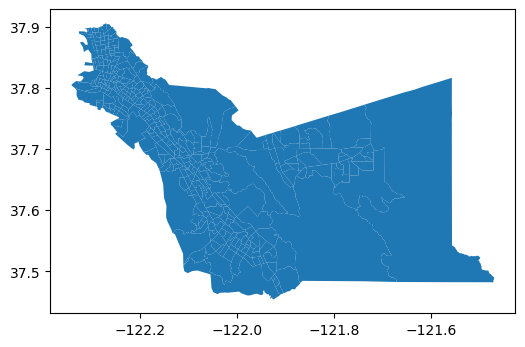

In [3]:
bnd.plot(figsize=(6, 6))

In [4]:
# optional save, already cached
bnd.to_file("alameda_tracts.gpkg")
bnd.to_file("alameda_tracts.shp")

### 4.2 `acquire.join_data()` - join boundaries with tables

In [5]:
select_vars = {'B08006_017E': 'wfh_workers', 'B08101_001E': 'total_workers'}

df = acquire.get_census(
    variables=select_vars,
    geography='tract',
    state='CA',
    county='Alameda',
    year=2021,
    dataset='acs5'
)

bnd = acquire.get_boundaries(
    geography='tract',
    state='CA',
    county='Alameda',
    year=2021
)

gdf_joined = acquire.join_data(df, bnd, add_area=True)
gdf_joined.head()

Resolving geography...
  State: California (CA, FIPS: 06)
  County: Alameda County (FIPS: 001)

Fetching data...
  Product: acs5 (2021)
  Geography: Tract
  Variables: 2


Downloading: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]



Done!
  State: California (CA, FIPS: 06)
  County: Alameda County (FIPS: 001)
Fetching boundaries...


,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME_x,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,...,ALAND,AWATER,geometry,wfh_workers,total_workers,NAME_y,state,county,tract,area_sqkm
0,06,001,451704,1400000US06001451704,06001451704,4517.04,Census Tract 4517.04,CA,Alameda County,California,...,2005363,0,"POLYGON ((-121.79849 37.66071, -121.79821 37.6...",370.0,2110.0,"Census Tract 4517.04, Alameda County, California",06,001,451704,2.017626
1,06,001,428301,1400000US06001428301,06001428301,4283.01,Census Tract 4283.01,CA,Alameda County,California,...,4300902,1597298,"POLYGON ((-122.25877 37.73788, -122.25208 37.7...",524.0,3964.0,"Census Tract 4283.01, Alameda County, California",06,001,428301,4.554624
2,06,001,407000,1400000US06001407000,06001407000,4070,Census Tract 4070,CA,Alameda County,California,...,862936,0,"POLYGON ((-122.20982 37.78830, -122.20680 37.7...",529.0,2891.0,"Census Tract 4070, Alameda County, California",06,001,407000,0.861642
3,06,001,422400,1400000US06001422400,06001422400,4224,Census Tract 4224,CA,Alameda County,California,...,475566,0,"POLYGON ((-122.27375 37.87779, -122.26918 37.8...",496.0,2466.0,"Census Tract 4224, Alameda County, California",06,001,422400,0.476541
4,06,001,423200,1400000US06001423200,06001423200,4232,Census Tract 4232,CA,Alameda County,California,...,456778,0,"POLYGON ((-122.29775 37.86794, -122.29223 37.8...",290.0,1372.0,"Census Tract 4232, Alameda County, California",06,001,423200,0.456690


### 4.3 power use case: multi-variable, multi-cbsa batch download

In [6]:
import pycen
from pycen import explore, acquire
import geopandas as gpd

select_vars = { 'B19001I_015E' : 'latino_125to150',
                'B19001I_016E' : 'latino_150to200',
                'B19001I_017E' : 'latino_morethan200',
                'B19001B_015E' : 'black_125to150',
                'B19001B_016E' : 'black_150to200',
                'B19001B_017E' : 'black_morethan200',
                'B19001D_015E' : 'asian_125to150',
                'B19001D_016E' : 'asian_150to200',
                'B19001D_017E' : 'asian_morethan200',
                'B19001H_015E' : 'white_125to150',
                'B19001H_016E' : 'white_150to200',
                'B19001H_017E' : 'white_morethan200',
}

# top 20 by population cbsa
top20_cbsa = acquire.get_census(['B01003_001E'],geography='CBSA',year=2023,dataset='acs5').dropna(subset=['B01003_001E']).sort_values('B01003_001E',ascending=False).head(20)
top20_cbsa

Resolving geography...

Fetching data...
  Product: acs5 (2023)
  Geography: Cbsa
  Variables: 1


Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Done!


,B01003_001E,NAME,metropolitan statistical area/micropolitan statistical area,GEOID
607,19756722.0,"New York-Newark-Jersey City, NY-NJ Metro Area",35620,35620
496,13012469.0,"Los Angeles-Long Beach-Anaheim, CA Metro Area",31080,31080
162,9359555.0,"Chicago-Naperville-Elgin, IL-IN Metro Area",16980,16980
210,7807555.0,"Dallas-Fort Worth-Arlington, TX Metro Area",19100,19100
386,7274714.0,"Houston-Pasadena-The Woodlands, TX Metro Area",26420,26420
892,6263796.0,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",47900,47900
661,6241882.0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Me...",37980,37980
50,6176937.0,"Atlanta-Sandy Springs-Roswell, GA Metro Area",12060,12060
545,6138876.0,"Miami-Fort Lauderdale-West Palm Beach, FL Metr...",33100,33100
662,4941206.0,"Phoenix-Mesa-Chandler, AZ Metro Area",38060,38060


In [7]:
# get their coverage state
state_list = sorted(top20_cbsa["NAME"].dropna().str.extractall(r"([A-Z]{2})")[0].unique())
state_list

['AZ',
 'CA',
 'CO',
 'DC',
 'DE',
 'FL',
 'GA',
 'IL',
 'IN',
 'MA',
 'MD',
 'MI',
 'MN',
 'NH',
 'NJ',
 'NY',
 'PA',
 'TX',
 'VA',
 'WA',
 'WI',
 'WV']

In [ ]:
# get coverage states-bounded, tract-level desired variables
tract_gdf = acquire.get_censhp(
    variables=select_vars,
    geography="tract",
    state=state_list,
    year=2023,
    dataset="acs5",
)

In [9]:
# get cbsa boundaries (all)
cbsa_bnd = acquire.get_boundaries("cbsa", year=2023)
cbsa_bnd = cbsa_bnd[cbsa_bnd["GEOID"].astype(str).isin(top20_cbsa["GEOID"].astype(str))]
cbsa_bnd = cbsa_bnd[["GEOID", "NAME", "geometry"]]

Fetching boundaries...


In [10]:
# subset of top 20 cbsa boundaries
cbsa_ids = top20_cbsa["GEOID"].astype(str)
cbsa_bnd = acquire.get_boundaries("cbsa", year=2023)
cbsa_bnd20 = cbsa_bnd[cbsa_bnd["GEOID"].astype(str).isin(cbsa_ids)][["GEOID", "NAME", "geometry"]]

Fetching boundaries...


In [11]:
# single spatial join
# top 20 cbsa-bounded, tract-level data
tract_gdf = tract_gdf.to_crs(cbsa_bnd.crs)
tract_cbsa = gpd.sjoin(tract_gdf, cbsa_bnd20, how="inner", predicate="intersects")

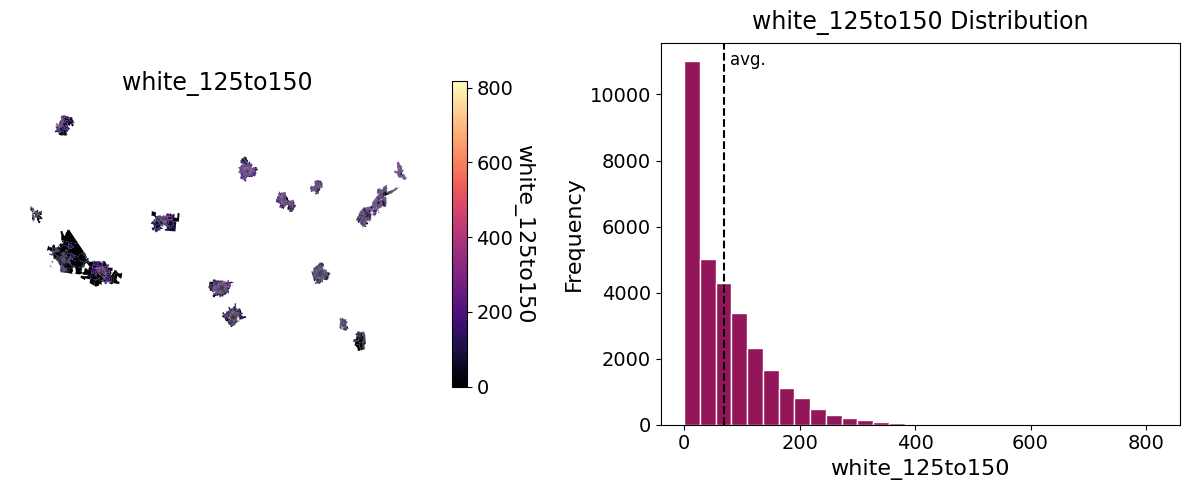

In [12]:
# save
acquire.quick_viz(tract_cbsa,'white_125to150',save_path='top20cbsa_white_125to150.png')

In [13]:
# save output
tract_cbsa.to_file('tract_cbsa.gpkg')
tract_cbsa.to_file('tract_cbsa.shp')

/var/folders/zg/wfxc09v55hd_4n44c2wwhcxw0000gn/T/ipykernel_66734/2595394233.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  tract_cbsa.to_file('tract_cbsa.shp')


### 4.4 geo lookup helpers

In [14]:
from pycen import geography

#### 4.4.0 geography search
search for any level of geography, and return all associated information

In [15]:
geography.search('Oakland', state='CA')

{'state': {'name': 'California', 'abbr': 'CA', 'fips': '06'},
 'places': [{'fips': '53000', 'name': 'Oakland city', 'state_fips': '06'}],
 'counties': [{'fips': '001', 'name': 'Alameda', 'state_fips': '06'}]}

#### 4.4.1 state and county lookup

In [16]:
geography.state('CA') # can also search by 'California' or fips code '06'

{'name': 'California', 'abbr': 'CA', 'fips': '06'}

In [17]:
geography.county('Alameda', state='CA')

{'name': 'Alameda', 'fips': '001', 'state_fips': '06'}

#### 4.4.2 list geographies

In [18]:
geography.list_places('CA', query='Oakland') # minimal search

,NAME,NAMELSAD,GEOID,PLACEFP,STATEFP
68,Oakland,Oakland city,0653000,53000,06


In [19]:
pycen.geography.list_cbsa(query='new york',year=2023, limit=5) # specify year and return limit if multi-match

,NAME,GEOID,CBSAFP
455,"New York-Newark-Jersey City, NY-NJ",35620,35620


In [20]:
pycen.geography.list_csa(query='detroit',year=2023, limit=5) # look up csa name

,NAME,GEOID,CSAFP
86,"Detroit-Warren-Ann Arbor, MI",220,220


In [21]:
geography.list_counties('CA')

[{'name': 'Alameda', 'fips': '001'},
 {'name': 'Alpine', 'fips': '003'},
 {'name': 'Amador', 'fips': '005'},
 {'name': 'Butte', 'fips': '007'},
 {'name': 'Calaveras', 'fips': '009'},
 {'name': 'Colusa', 'fips': '011'},
 {'name': 'Contra Costa', 'fips': '013'},
 {'name': 'Del Norte', 'fips': '015'},
 {'name': 'El Dorado', 'fips': '017'},
 {'name': 'Fresno', 'fips': '019'},
 {'name': 'Glenn', 'fips': '021'},
 {'name': 'Humboldt', 'fips': '023'},
 {'name': 'Imperial', 'fips': '025'},
 {'name': 'Inyo', 'fips': '027'},
 {'name': 'Kern', 'fips': '029'},
 {'name': 'Kings', 'fips': '031'},
 {'name': 'Lake', 'fips': '033'},
 {'name': 'Lassen', 'fips': '035'},
 {'name': 'Los Angeles', 'fips': '037'},
 {'name': 'Madera', 'fips': '039'},
 {'name': 'Marin', 'fips': '041'},
 {'name': 'Mariposa', 'fips': '043'},
 {'name': 'Mendocino', 'fips': '045'},
 {'name': 'Merced', 'fips': '047'},
 {'name': 'Modoc', 'fips': '049'},
 {'name': 'Mono', 'fips': '051'},
 {'name': 'Monterey', 'fips': '053'},
 {'name':

#### 4.4.3 print nested geo hiearchies

In [22]:
geography.constraints('acs5', 2023)

{'dataset': 'acs5',
 'year': 2023,
 'source': 'live',
 'geographies': [{'key': 'state > county > tract > block group',
   'normalized': 'state > county > tract > block group',
   'base': 'block group',
   'required_in': ['state', 'county', 'tract'],
   'for_token': 'block group:*',
   'state_required': True,
   'county_required': True},
  {'key': 'state > county > tract',
   'normalized': 'state > county > tract',
   'base': 'tract',
   'required_in': ['state', 'county'],
   'for_token': 'tract:*',
   'state_required': True,
   'county_required': True},
  {'key': 'metropolitan statistical area/micropolitan statistical area > metropolitan division > state (or part) > county',
   'normalized': 'metropolitan statistical area/micropolitan statistical area > metropolitan division > state (or part) > county',
   'base': 'county',
   'required_in': ['metropolitan statistical area/micropolitan statistical area',
    'metropolitan division',
    'state (or part)'],
   'for_token': 'county:*',
 

In [23]:
geography.load_geography_catalog('acs5', 2023) # raw catalog from census API

(['american indian area (off-reservation trust land only)/hawaiian home land',
  'american indian area (off-reservation trust land only)/hawaiian home land > tribal census tract (or part)',
  'american indian area (off-reservation trust land only)/hawaiian home land > tribal census tract (or part) > tribal block group (or part)',
  'american indian area/alaska native area (reservation or statistical entity only)',
  'american indian area/alaska native area (reservation or statistical entity only) > tribal census tract (or part)',
  'american indian area/alaska native area (reservation or statistical entity only) > tribal census tract (or part) > tribal block group (or part)',
  'american indian area/alaska native area/hawaiian home land',
  'american indian area/alaska native area/hawaiian home land > state (or part)',
  'american indian area/alaska native area/hawaiian home land > state (or part) > county (or part)',
  'american indian area/alaska native area/hawaiian home land > stat